<a href="https://colab.research.google.com/github/philBram/machine_learning_with_tensorflow_project/blob/main/colorize_black_and_white_summer2winter_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Concatenate

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Create gray images from the color images and save them in a new folder

In [ ]:
def create_black_and_white(source_dir, dest_dir):
    image_list = sorted(os.listdir(source_dir))
    
    for image in image_list:
        color_image_path = os.path.join(source_dir, image)
        gray_image_path = os.path.join(dest_dir, image)
        
        color_image = cv2.imread(color_image_path)
        gray_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)
        
        cv2.imwrite(gray_image_path, gray_image)

In [ ]:
#train_dir = 'train'
#train_gray_dir = 'train_gray'
#val_dir = 'test'
#val_gray_dir = 'test_gray'

#train_dir = '/content/drive/MyDrive/train'
#train_gray_dir = '/content/drive/MyDrive/train_gray'
#val_dir = '/content/drive/MyDrive/test'
#val_gray_dir = '/content/drive/MyDrive/test_gray'

train_dir = '/content/drive/MyDrive/trainA'
train_gray_dir = '/content/drive/MyDrive/trainA_gray'
val_dir = '/content/drive/MyDrive/testA'
val_gray_dir = '/content/drive/MyDrive/testA_gray'
data_dir = 'data'

train_data_dir = os.path.join(train_dir, data_dir)
val_data_dir = os.path.join(val_dir, data_dir)

train_gray_data_dir = os.path.join(train_gray_dir, data_dir)
val_gray_data_dir = os.path.join(val_gray_dir, data_dir)

if os.path.exists(train_gray_dir) and os.path.exists(val_gray_dir):
    print('Images are already grayed.')
else: 
    os.mkdir(train_gray_dir)
    os.mkdir(val_gray_dir)
    os.mkdir(train_gray_data_dir)
    os.mkdir(val_gray_data_dir)

    create_black_and_white(train_data_dir, train_gray_data_dir)
    create_black_and_white(val_data_dir, val_gray_data_dir)

Images are already grayed.


# Show number of train and validation images

In [ ]:
print('Total number of training images: ', len(os.listdir(train_data_dir)))
print('Total number of validation images: ', len(os.listdir(val_data_dir)))

Total number of training images:  1231
Total number of validation images:  309


# Show gray and color example images that are used for input and labels

In [ ]:
def show_images(source_dir, seed_value, ncols=5, nrows=5, gray=False):
    fig = plt.gcf()
    fig.set_size_inches(ncols * 2, nrows * 2)

    images = np.array(sorted(os.listdir(source_dir)))
    dir_size = len(os.listdir(source_dir))
    
    np.random.seed(seed_value)
    pic_index = np.random.randint(0, dir_size, ncols * nrows)

    images_random = [os.path.join(source_dir, fname) for fname in images[pic_index]]
    
    # display random color images
    for i, img_path in enumerate(images_random):
        sp = plt.subplot(nrows, ncols, i + 1)
        sp.axis('Off')

        img = mpimg.imread(img_path)

        if gray:
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(img)
  
    plt.tight_layout()
    plt.show()

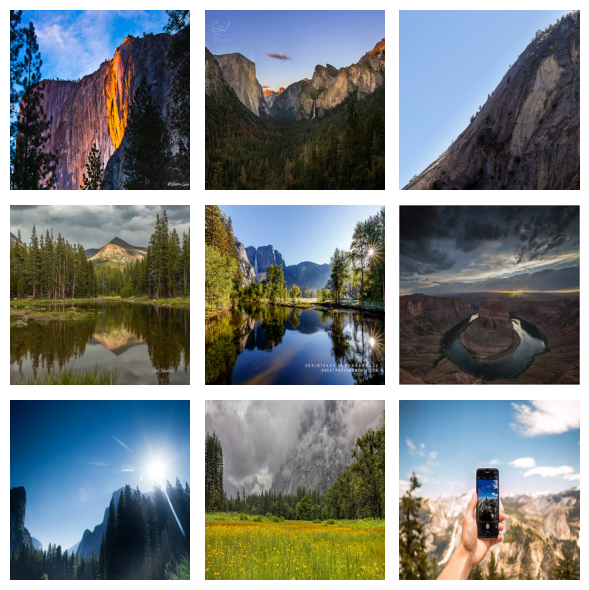

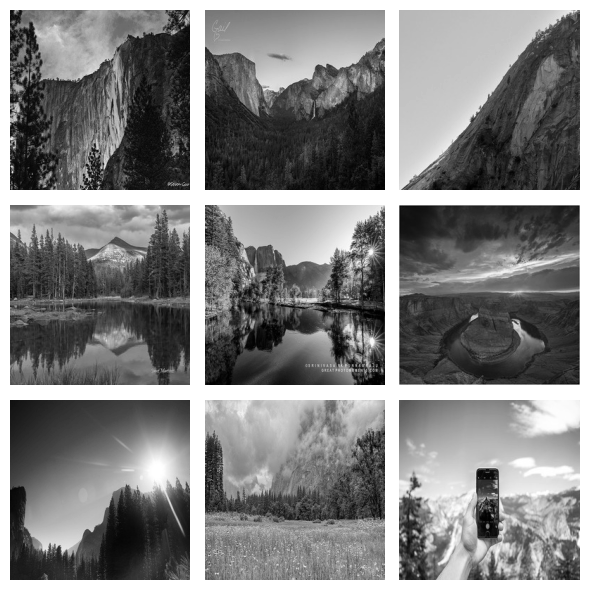

In [ ]:
seed_value = np.random.randint(0, 100)

show_images(train_data_dir, seed_value, ncols=3, nrows=3)
show_images(train_gray_data_dir, seed_value, ncols=3, nrows=3, gray=True)

# Create instances of the ImageDataGenerator for the training and validation inputs and labels

In [ ]:
batch_size = 32
image_size = (256, 256)
seed = 42
np.random.seed(seed)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_input_generator = train_datagen.flow_from_directory(
    train_gray_dir,
    target_size=image_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode=None, # Set class_mode to None to obtain only the input images
    shuffle=False, # Disable shuffling to ensure correct matching between input and label images
    seed=seed
)

train_label_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode=None, # Set class_mode to None to obtain only the label images
    shuffle=False, # Disable shuffling to ensure correct matching between input and label images
    seed=seed
)

val_input_generator = val_datagen.flow_from_directory(
    val_gray_dir,
    target_size=image_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode=None, # Set class_mode to None to obtain only the input images
    shuffle=False, # Disable shuffling to ensure correct matching between input and label images
    seed=seed
)

val_label_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode=None, # Set class_mode to None to obtain only the label images
    shuffle=False, # Disable shuffling to ensure correct matching between input and label images
    seed=seed
)

train_generator = zip(train_input_generator, train_label_generator)
val_generator = zip(val_input_generator, val_label_generator)

Found 1231 images belonging to 1 classes.
Found 1231 images belonging to 1 classes.
Found 309 images belonging to 1 classes.
Found 309 images belonging to 1 classes.


# Create U-Net Model with gray images as input and color images as labels
![image](https://www.researchgate.net/publication/331406702/figure/download/fig2/AS:731276273262594@1551361258173/Illustration-of-the-U-net-architecture-The-figure-illustrates-the-U-net-architecture.png)

In [ ]:
def unet_model(input_shape, dropout_rate=0.2):
    input_layer = Input(shape=input_shape)
    
    # Encoding
    
    conv_1_1 = Conv2D(64, (3, 3), padding='same', activation='relu')(input_layer)
    drop_out_1 = Dropout(dropout_rate)(conv_1_1)
    conv_1_2 = Conv2D(64, (3, 3), padding='same', activation='relu')(drop_out_1)
    max_pooling_1 = MaxPooling2D((2, 2))(conv_1_2)
    
    conv_2_1 = Conv2D(128, (3, 3), padding='same', activation='relu')(max_pooling_1)
    drop_out_2 = Dropout(dropout_rate)(conv_2_1)
    conv_2_2 = Conv2D(128, (3, 3), padding='same', activation='relu')(drop_out_2)
    max_pooling_2 = MaxPooling2D((2, 2))(conv_2_2)
    
    conv_3_1 = Conv2D(256, (3, 3), padding='same', activation='relu')(max_pooling_2)
    drop_out_3 = Dropout(dropout_rate)(conv_3_1)
    conv_3_2 = Conv2D(256, (3, 3), padding='same', activation='relu')(drop_out_3)
    max_pooling_3 = MaxPooling2D((2, 2))(conv_3_2)
    
    conv_4_1 = Conv2D(512, (3, 3), padding='same', activation='relu')(max_pooling_3)
    drop_out_4 = Dropout(dropout_rate)(conv_4_1)
    conv_4_2 = Conv2D(512, (3, 3), padding='same', activation='relu')(drop_out_4)
    max_pooling_4 = MaxPooling2D((2, 2))(conv_4_2)
    
    conv_5_1 = Conv2D(1024, (3, 3), padding='same', activation='relu')(max_pooling_4)
    drop_out_5 = Dropout(dropout_rate)(conv_5_1)
    conv_5_2 = Conv2D(1024, (3, 3), padding='same', activation='relu')(drop_out_5)
    conv_trans_5 = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(conv_5_2)
    
    # Decoding
    
    concat_4 = Concatenate()([conv_trans_5, conv_4_2])
    conv_up_4_1 = Conv2D(512, (3, 3), padding='same', activation='relu')(concat_4)
    drop_out_up_4 = Dropout(dropout_rate)(conv_up_4_1)
    conv_up_4_2 = Conv2D(512, (3, 3), padding='same', activation='relu')(drop_out_up_4)
    conv_trans_4 = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(conv_up_4_2)
    
    concat_3 = Concatenate()([conv_trans_4, conv_3_2])
    conv_up_3_1 = Conv2D(256, (3, 3), padding='same', activation='relu')(concat_3)
    drop_out_up_3 = Dropout(dropout_rate)(conv_up_3_1)
    conv_up_3_2 = Conv2D(256, (3, 3), padding='same', activation='relu')(drop_out_up_3)
    conv_trans_3 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(conv_up_3_2)
    
    concat_2 = Concatenate()([conv_trans_3, conv_2_2])
    conv_up_2_1 = Conv2D(128, (3, 3), padding='same', activation='relu')(concat_2)
    drop_out_up_2 = Dropout(dropout_rate)(conv_up_2_1)
    conv_up_2_2 = Conv2D(128, (3, 3), padding='same', activation='relu')(drop_out_up_2)
    conv_trans_2 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(conv_up_2_2)
    
    concat_1 = Concatenate()([conv_trans_2, conv_1_2])
    conv_up_1_1 = Conv2D(64, (3, 3), padding='same', activation='relu')(concat_1)
    drop_out_up_1 = Dropout(dropout_rate)(conv_up_1_1)
    conv_up_1_2 = Conv2D(64, (3, 3), padding='same', activation='relu')(drop_out_up_1)
    conv_out = Conv2D(3, (1, 1), padding='same', activation='relu')(conv_up_1_2)
    
    model = tf.keras.Model(inputs=input_layer, outputs=conv_out)
    
    return model

In [ ]:
input_shape = image_size + (1,)
dropout_rate = 0.1

model = unet_model(input_shape, dropout_rate)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 64  0           ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
learning_rate=0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss=tf.keras.losses.mean_squared_error,
              metrics=['accuracy'])

In [ ]:
model_file = '/content/drive/MyDrive/model2.h5'
history_file = '/content/drive/MyDrive/history2.pkl'

if os.path.exists(model_file) and os.path.exists(history_file);
  model = tf.keras.models.load_model(model_file)
else:
  epochs = 100
  steps_per_epoch = np.floor(len(os.listdir(train_data_dir)) / batch_size) 
  validation_steps = np.floor(len(os.listdir(val_data_dir)) / batch_size) 
  
  history = model.fit(
      train_generator,
      steps_per_epoch=steps_per_epoch,
      epochs=epochs,
      validation_data=val_generator,
      validation_steps=validation_steps)

Epoch 1/100
38/38 [==============================] - 320s 7s/step - loss: 0.0707 - accuracy: 0.3028 - val_loss: 0.0235 - val_accuracy: 0.3020
Epoch 2/100
38/38 [==============================] - 102s 2s/step - loss: 0.0154 - accuracy: 0.3175 - val_loss: 0.0168 - val_accuracy: 0.3176
Epoch 3/100
38/38 [==============================] - 80s 2s/step - loss: 0.0130 - accuracy: 0.3238 - val_loss: 0.0139 - val_accuracy: 0.3666
Epoch 4/100
38/38 [==============================] - 81s 2s/step - loss: 0.0119 - accuracy: 0.3309 - val_loss: 0.0126 - val_accuracy: 0.3792
Epoch 5/100
38/38 [==============================] - 80s 2s/step - loss: 0.0111 - accuracy: 0.3389 - val_loss: 0.0120 - val_accuracy: 0.4055
Epoch 6/100
38/38 [==============================] - 81s 2s/step - loss: 0.0107 - accuracy: 0.3548 - val_loss: 0.0114 - val_accuracy: 0.4316
Epoch 7/100
38/38 [==============================] - 81s 2s/step - loss: 0.0103 - accuracy: 0.3742 - val_loss: 0.0112 - val_accuracy: 0.4526
Epoch 8/100

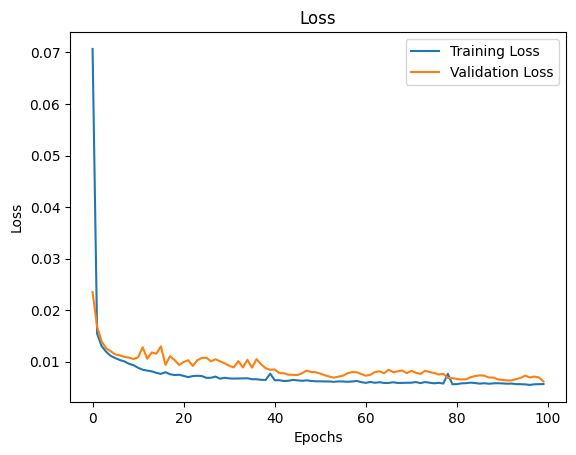

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.title('Loss')
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

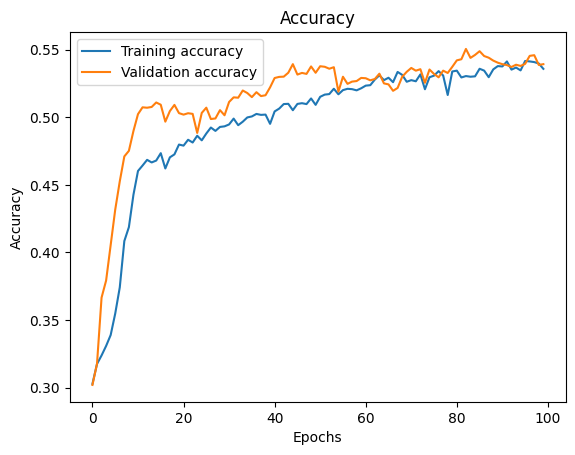

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.title('Accuracy')
plt.plot(accuracy, label='Training accuracy')
plt.plot(val_accuracy, label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

10/10 [==============================] - 4s 484ms/step


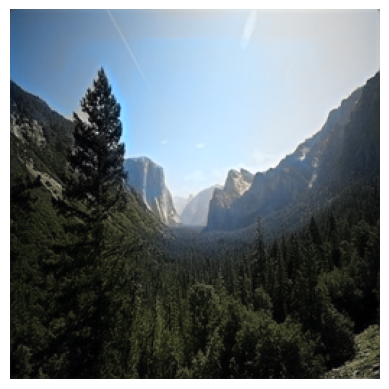

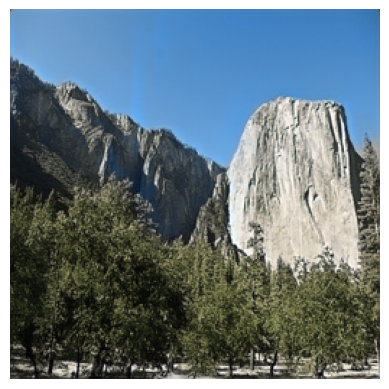

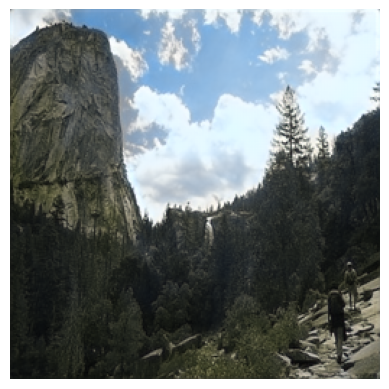

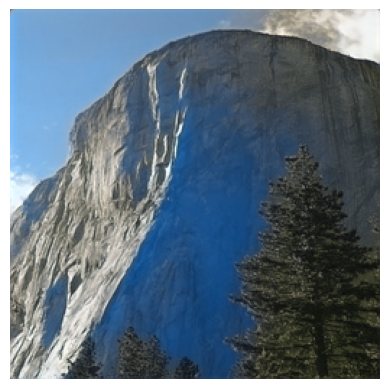

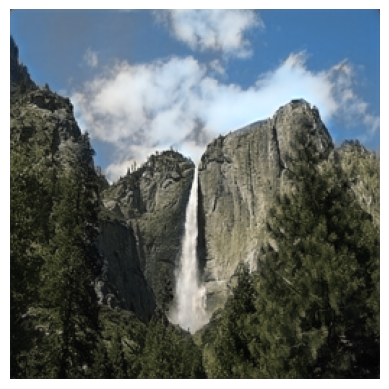

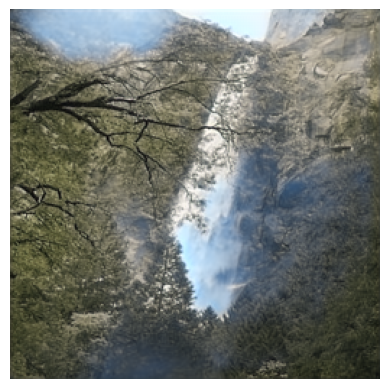

In [ ]:
predicted_images = model.predict(val_input_generator)

for i in predicted_images[:5]:
    plt.imshow(i)
    plt.axis('off')
    plt.show()

# Save model and history

In [ ]:
model.save('/content/drive/MyDrive/model2.h5')

with open('/content/drive/MyDrive/history2.pkl', 'wb') as f:
    pickle.dump(history.history, f)